1.Segmentaion

In [3]:
import numpy as np                          # Numerical computations (arrays, math, stats)
import tifffile as tiff                     # Read/write hyperspectral .tiff images
from skimage import filters                 # Image processing filters (Laplacian, Gaussian, etc.)
from skimage.filters import threshold_otsu  # Otsu thresholding for segmentation
from sklearn.cluster import KMeans          # KMeans clustering algorithm
from ipywidgets import interact, IntSlider  # Interactive sliders in Jupyter Notebook
import matplotlib.pyplot as plt             # Visualization (plots, images)
from matplotlib import cm                   # Colormap utilities
from matplotlib.colors import ListedColormap # Custom colormaps for clustering
from matplotlib.patches import Patch        # Legend patches for clusters

# Define wavelength range (400–1000 nm, total 204 bands)
num_bands = 204
wavelength_start = 400
wavelength_end = 1000
wavelengths = np.linspace(wavelength_start, wavelength_end, num_bands)  # evenly spaced values

# Function to calculate metrics of one band
def calculate_band_metrics(band_array):
    band_norm = (band_array - np.nanmin(band_array)) / (np.nanmax(band_array) - np.nanmin(band_array) + 1e-8)

    brightness = np.nanmean(band_norm)
    contrast = np.nanstd(band_norm)
    sharpness = filters.laplace(band_norm).var()

    highpass = band_norm - filters.gaussian(band_norm, sigma=1)
    noise = np.nanstd(highpass)
    signal = np.sqrt(np.nanmean(band_norm**2))
    snr = 20 * np.log10(signal / (noise + 1e-8))

    return {
        "Brightness": brightness,
        "Contrast": contrast,
        "Sharpness": sharpness,
        "SNR(dB)": snr
    }

# Interactive function for displaying band metrics and plots
def show_band_metrics_interactive(img_id, band_idx):
    file_path = f"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/image/{img_id:05d}.tiff"

    try:
        cube = tiff.imread(file_path)
        bands, rows, cols = cube.shape

        print(f"Loaded Image ID: {img_id}")
        print(f"Image width: {cols}, height: {rows}, bands: {bands}, dtype: {cube.dtype}")
        bit_depth = cube.dtype.itemsize * 8
        print(f"Bit depth: {bit_depth}\n")

        cube = np.transpose(cube, (1, 2, 0))
        band_array = cube[:, :, band_idx]

        metrics = calculate_band_metrics(band_array)

        if len(wavelengths) == bands:
            band_wavelength = wavelengths[band_idx]
            print(f"Selected Band: {band_idx} | Wavelength: {band_wavelength:.2f} nm")
        else:
            print(f"Selected Band: {band_idx} | Wavelength info not available")

        print(f"Brightness: {metrics['Brightness']:.4f}")
        print(f"Contrast: {metrics['Contrast']:.4f}")
        print(f"Sharpness: {metrics['Sharpness']:.4f}")
        print(f"SNR(dB): {metrics['SNR(dB)']:.4f}")

        thresh = threshold_otsu(band_array)
        mask = band_array > thresh
        segmented_leaf = band_array * mask

        n_clusters = 3
        if np.sum(mask) > 10:
            leaf_pixels_band = band_array[mask].reshape(-1, 1)
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(leaf_pixels_band)
            disease_mask = np.zeros_like(band_array)
            disease_mask[mask] = kmeans.labels_ + 1
        else:
            disease_mask = np.zeros_like(band_array)
            kmeans = None

        leaf_pixels_cube = cube[mask, :]
        mean_spectrum = np.mean(leaf_pixels_cube, axis=0)
        min_spectrum = np.min(leaf_pixels_cube, axis=0)
        std_spectrum = np.std(leaf_pixels_cube, axis=0)

        # ===== Visualization (2x2 layout) =====
        fig, axes = plt.subplots(2, 2, figsize=(12, 4))
        axes = axes.ravel()

        # RGB Composite
        def find_band_index(target_wl):
            return np.argmin(np.abs(wavelengths - target_wl))

        r_idx = find_band_index(660)
        g_idx = find_band_index(550)
        b_idx = find_band_index(470)

        rgb_img = np.stack([cube[:, :, r_idx],
                            cube[:, :, g_idx],
                            cube[:, :, b_idx]], axis=-1)
        rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img) + 1e-8)

        axes[0].imshow(rgb_img)
        axes[0].set_title(f"Original Leaf ({img_id})")
        axes[0].axis("off")

        # Otsu mask
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title("Otsu Binary Mask", fontsize=12)
        axes[1].axis("off")

        # Segmented leaf
        axes[2].imshow(segmented_leaf, cmap='gray')
        axes[2].set_title("Segmented Leaf (Grayscale)", fontsize=12)
        axes[2].axis("off")

        # Leaf clusters
        cluster_cmap = ListedColormap(["black", "green", "orange", "blue"])
        axes[3].imshow(disease_mask, cmap=cluster_cmap, vmin=0, vmax=3)
        axes[3].set_title("Leaf Clusters (Healthy, Mild, Severe)", fontsize=12)
        axes[3].axis("off")
        legend_elements = [
            Patch(facecolor="green", edgecolor='k', label="Healthy"),
            Patch(facecolor="orange", edgecolor='k', label="Mild Disease"),
            Patch(facecolor="blue", edgecolor='k', label="Severe Disease")
        ]
        axes[3].legend(handles=legend_elements, loc='upper right', fontsize=8)

        plt.tight_layout()
        plt.show()

        # ===== Summary Spectrum =====
        plt.figure(figsize=(9, 6))
        plt.plot(wavelengths, mean_spectrum, '-g', label="Mean Reflectance")
        plt.plot(wavelengths, min_spectrum, '-r', label="Minimum Reflectance")
        plt.plot(wavelengths, std_spectrum, '-b', label="Std Deviation")

        min_val = np.min(min_spectrum)
        min_idx = np.argmin(min_spectrum)
        min_wl = wavelengths[min_idx]
        plt.scatter(min_wl, min_val, color='red', zorder=5)
        plt.text(min_wl + 5, min_val, f"Min = {min_val:.4f} @ {min_wl:.1f} nm", color='red', fontsize=10, va='bottom')

        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Reflectance")
        plt.title(f"Summary Spectrum (Image ID {img_id})")
        plt.grid(True)
        plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.show()

        # ===== Cluster-wise Spectra =====
        if kmeans is not None:
            cluster_names = ["Healthy", "Mild Disease", "Severe Disease"]
            cluster_colors = ["green", "orange", "blue"]

            plt.figure(figsize=(9, 6))
            for cluster_id in range(n_clusters):
                cluster_mask_pixels = (disease_mask == (cluster_id + 1))
                if np.sum(cluster_mask_pixels) > 0:
                    cluster_pixels_cube = cube[cluster_mask_pixels, :]
                    cluster_mean = np.mean(cluster_pixels_cube, axis=0)
                    plt.plot(wavelengths, cluster_mean,
                             label=f"{cluster_names[cluster_id]} Spectrum",
                             color=cluster_colors[cluster_id])
            plt.xlabel("Wavelength (nm)")
            plt.ylabel("Reflectance")
            plt.title(f"Cluster-wise Spectra (Image ID {img_id})")
            plt.grid(True)
            plt.legend()
            plt.show()

        # ===== Individual ROI Pixel Spectra =====
        num_pixels = leaf_pixels_cube.shape[0]
        fig, ax = plt.subplots(figsize=(9, 6))
        for i in range(num_pixels):
            ax.plot(wavelengths, leaf_pixels_cube[i],
                    color=cm.viridis(i / num_pixels), linewidth=1)

        sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=0, vmax=num_pixels - 1))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label("Pixel Index (ROI)")

        ax.set_xlabel("Wavelength (nm)")
        ax.set_ylabel("Reflectance")
        ax.set_title(f"Spectral Curves of ROI Pixels (Image ID {img_id})")
        plt.show()

    except FileNotFoundError:
        print(f"File for Image ID {img_id} not found.")

# Dataset info
min_id = 0
max_id = 2409
first_img_file = f"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/image/{min_id:05d}.tiff"
first_cube = tiff.imread(first_img_file)
total_bands = first_cube.shape[0]

# Interactive sliders
interact(
    show_band_metrics_interactive,
    img_id=IntSlider(min=min_id, max=max_id, step=1, value=min_id, description='Image ID'),
    band_idx=IntSlider(min=0, max=total_bands-1, step=1, value=0, description='Band')
)


interactive(children=(IntSlider(value=0, description='Image ID', max=2409), IntSlider(value=0, description='Ba…

<function __main__.show_band_metrics_interactive(img_id, band_idx)>

2.Exceptional Images

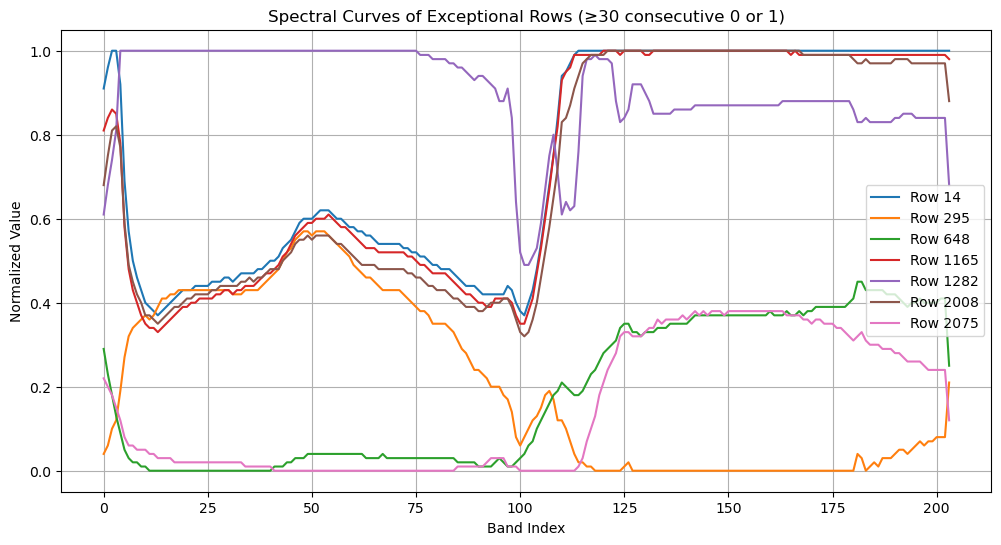

Total Exceptional Rows: 7
Exceptional Row Indexes: [14, 295, 648, 1165, 1282, 2008, 2075]


In [1]:
import pandas as pd                       # pandas: for reading CSV files and data manipulation
import numpy as np                        # numpy: for numerical operations and arrays
import matplotlib.pyplot as plt           # matplotlib: for plotting data

# Step 1: Load dataset
file_path = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/normalized_minmax_with_target.csv"
                                          # Full path to your CSV file (raw string so backslashes work)
df = pd.read_csv(file_path)               # Read the CSV file into a pandas DataFrame

# Drop target column if it exists
if 'Yield' in df.columns:
    feature_df = df.drop(columns=['Yield'])  # If 'Yield' column exists, drop it (keep only features)
else:
    feature_df = df                         # Otherwise, keep the whole DataFrame as features

num_bands = feature_df.shape[1]             # Number of spectral bands (columns) per row

# Step 2: Identify exceptional rows
min_run_length = 30                   # Condition: ≥25 consecutive values of 0 or 1
exceptional_rows = []                       # Empty list to store (row_index, row_data) of exceptional rows

# Loop over each row of the feature matrix
for idx, row in feature_df.iterrows():
    data = row.values.astype(float)         # Convert row into numpy array (float type)

    run_length = 1                          # Counter for length of consecutive sequence
    exceptional = False                     # Flag: will be True if this row is exceptional

    # Loop through the row values (start from index 1 to compare with previous element)
    for i in range(1, len(data)):
        # Only count if the value is exactly 0 or 1
        # and if it matches the previous value (consecutive repetition)
        if data[i] in [0, 1] and data[i] == data[i-1]:
            run_length += 1                 # Increase the consecutive run counter
            if run_length >= min_run_length:
                exceptional = True          # If the run is long enough, mark as exceptional
                break                       # Stop checking further in this row
        else:
            run_length = 1                  # Reset counter if values differ or not 0/1

    # After finishing the loop, if exceptional, save this row
    if exceptional:
        exceptional_rows.append((idx+2, data))  # Store tuple (row_index, row_data)

# Step 3: Plot exceptional rows with row index labels
if exceptional_rows:
    plt.figure(figsize=(12,6))             # Set figure size

    # Plot each exceptional row’s spectral curve
    for idx, data in exceptional_rows:
        plt.plot(range(len(data)), data, label=f'Row {idx}')  # Label with row index

    # Add title and axis labels
    plt.title(f"Spectral Curves of Exceptional Rows (≥{min_run_length} consecutive 0 or 1)")
    plt.xlabel("Band Index")                # x-axis = band number
    plt.ylabel("Normalized Value")          # y-axis = band value
    plt.grid(True)                          # Add grid for readability
    plt.legend()                            # Show legend (row indexes)
    plt.show()                              # Display the plot

    # Step 4: Print details
    print(f"Total Exceptional Rows: {len(exceptional_rows)}")  # Number of exceptional rows
    print("Exceptional Row Indexes:", [idx for idx, _ in exceptional_rows])  # Their indexes
else:
    print("No exceptional rows found!")     # If no exceptional row detected


In [22]:
import numpy as np                     # For numerical operations (arrays, math)
import tifffile as tiff                # For reading/writing hyperspectral .tiff images
from skimage import filters            # For image processing (e.g., Laplacian, Gaussian)
from skimage.filters import threshold_otsu  # For automatic Otsu thresholding
from sklearn.cluster import KMeans     # KMeans clustering algorithm
from ipywidgets import interact, IntSlider, IntText  # Interactive widgets for Jupyter
import matplotlib.pyplot as plt        # Plotting library
from matplotlib.colors import ListedColormap  # For discrete cluster color maps
from matplotlib.patches import Patch  # For adding legend boxes

# Define wavelength range
num_bands = 204                        # Total number of spectral bands
wavelength_start = 400
wavelength_end = 1000
wavelengths = np.linspace(wavelength_start, wavelength_end, num_bands)  # Wavelength array

# Function to calculate band metrics
def calculate_band_metrics(band_array):
    band_norm = (band_array - np.nanmin(band_array)) / (np.nanmax(band_array) - np.nanmin(band_array) + 1e-8)
    
    brightness = np.nanmean(band_norm)
    contrast = np.nanstd(band_norm)
    sharpness = filters.laplace(band_norm).var()
    
    highpass = band_norm - filters.gaussian(band_norm, sigma=1)
    noise = np.nanstd(highpass)
    signal = np.sqrt(np.nanmean(band_norm**2))
    snr = 20 * np.log10(signal / (noise + 1e-8))
    
    return {"Brightness": brightness, "Contrast": contrast, "Sharpness": sharpness, "SNR(dB)": snr}

# Interactive function
def show_band_metrics_interactive(img_id, band_idx):
    file_path = f"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/image/{img_id:05d}.tiff"

    try:
        cube = tiff.imread(file_path)
        bands, rows, cols = cube.shape

        print(f"\nLoaded Image ID: {img_id}")
        print(f"Image width: {cols}, height: {rows}, bands: {bands}, dtype: {cube.dtype}")
        bit_depth = cube.dtype.itemsize * 8
        print(f"Bit depth: {bit_depth}\n")

        cube = np.transpose(cube, (1, 2, 0))
        band_array = cube[:, :, band_idx]

        metrics = calculate_band_metrics(band_array)
        if len(wavelengths) == bands:
            band_wavelength = wavelengths[band_idx]
            print(f"Selected Band: {band_idx} | Wavelength: {band_wavelength:.2f} nm")
        print(f"Brightness: {metrics['Brightness']:.4f}")
        print(f"Contrast: {metrics['Contrast']:.4f}")
        print(f"Sharpness: {metrics['Sharpness']:.4f}")
        print(f"SNR(dB): {metrics['SNR(dB)']:.4f}")

        # Otsu threshold segmentation
        thresh = threshold_otsu(band_array)
        mask = band_array > thresh
        segmented_leaf = band_array * mask

        # KMeans clustering
        n_clusters = 3
        disease_mask = np.zeros_like(band_array)
        if np.sum(mask) > 10:
            leaf_pixels_band = band_array[mask].reshape(-1, 1)
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10).fit(leaf_pixels_band)
            disease_mask[mask] = kmeans.labels_ + 1

        # ===== Visualization (2x2 layout) =====
        fig, axes = plt.subplots(2, 2, figsize=(12, 4))
        axes = axes.ravel()

        # (0) RGB Composite
        def find_band_index(target_wl):
            return np.argmin(np.abs(wavelengths - target_wl))

        r_idx = find_band_index(660)
        g_idx = find_band_index(550)
        b_idx = find_band_index(470)

        rgb_img = np.stack([cube[:, :, r_idx],
                            cube[:, :, g_idx],
                            cube[:, :, b_idx]], axis=-1)
        rgb_img = (rgb_img - np.min(rgb_img)) / (np.max(rgb_img) - np.min(rgb_img) + 1e-8)

        axes[0].imshow(rgb_img)
        axes[0].set_title(f"Original Leaf ({img_id})")  # Added Image ID
        axes[0].axis("off")

        # (1) Otsu binary mask
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title("Otsu Binary Mask")
        axes[1].axis("off")

        # (2) Segmented leaf
        axes[2].imshow(segmented_leaf, cmap='gray')
        axes[2].set_title("Segmented Leaf (Grayscale)")
        axes[2].axis("off")

        # (3) Leaf clusters
        cluster_cmap = ListedColormap(["black", "green", "orange", "blue"])
        axes[3].imshow(disease_mask, cmap=cluster_cmap, vmin=0, vmax=3)
        axes[3].set_title("Leaf Clusters (Healthy, Mild, Severe)")
        axes[3].axis("off")

        # Cluster legend
        legend_elements = [
            Patch(facecolor="green", edgecolor='k', label="Healthy"),
            Patch(facecolor="orange", edgecolor='k', label="Mild Disease"),
            Patch(facecolor="blue", edgecolor='k', label="Severe Disease")
        ]
        axes[3].legend(handles=legend_elements, loc='upper right', fontsize=8)

        plt.tight_layout()
        plt.show()

    except FileNotFoundError:
        print(f"File for Image ID {img_id} not found.")

# Dataset info
min_id = 0
max_id = 2409
first_img_file = f"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/image/{min_id:05d}.tiff"
first_cube = tiff.imread(first_img_file)
total_bands = first_cube.shape[0]

# Interactive controls
interact(
    show_band_metrics_interactive,
    img_id=IntText(min=min_id, max=max_id, value=min_id, description='Image ID'),
    band_idx=IntSlider(min=0, max=total_bands-1, step=1, value=0, description='Band')
)


interactive(children=(IntText(value=0, description='Image ID'), IntSlider(value=0, description='Band', max=203…

<function __main__.show_band_metrics_interactive(img_id, band_idx)>

3.Image to xlsx

In [ ]:
# image to xlsx file convert
import numpy as np                     # For numerical operations
import tifffile as tiff                # To read hyperspectral .tiff images
from skimage.filters import threshold_otsu   # For automatic thresholding (segmentation)
import pandas as pd                    # To store and save tabular data (Excel)
import os                              # For file and directory handling

# Dataset info
data_dir = r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/image/"  
# Path to dataset folder containing hyperspectral images

all_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".tiff")])  
# List all .tiff files in dataset, sorted by name (00000.tiff → 02409.tiff)

num_bands = 204                        # Number of spectral bands per image
wavelengths = np.linspace(400, 1000, num_bands)  
# Create wavelength array from 400–1000 nm (evenly spaced for 204 bands)

# Yield example (0–2409)
num_images = 2410                      # Total images in dataset
np.random.seed(42)                     # Fix random seed for reproducibility
yield_values = np.round(np.random.uniform(3.0, 5.0, size=num_images), 2)  
# Simulated yield values between 3.0–5.0 (2 decimal places)

yield_dict = {i: yield_values[i] for i in range(num_images)}  
# Map each image ID to a simulated yield value

# Function: Extract Metrics
def extract_metrics(file_path):
    cube = tiff.imread(file_path)             # Read hyperspectral cube (bands, rows, cols)
    cube = np.transpose(cube, (1, 2, 0))      # Rearrange to (rows, cols, bands)

    ref_band = cube[:, :, 50]                 # Select one reference band (index 50 ~ ~520nm)
    otsu_thresh = threshold_otsu(ref_band)    # Compute Otsu threshold for segmentation
    mask = ref_band > otsu_thresh             # Binary mask (leaf pixels = True)

    leaf_pixels = cube[mask, :]               # Extract spectra of only leaf pixels
    mean_spectrum = np.mean(leaf_pixels, axis=0)  # Average reflectance across bands
    min_reflectance = np.min(leaf_pixels)     # Minimum reflectance value (for health check)

    return mean_spectrum, min_reflectance, otsu_thresh  
    # Return metrics for further processing

# Collect Data
records = []                                  # Empty list to store all rows

for file_name in all_files:                   # Loop through every TIFF image
    try:
        img_id = int(file_name.split(".")[0]) # Extract numeric ID from filename
        file_path = os.path.join(data_dir, file_name)  # Build full file path

        mean_spec, min_ref, otsu_val = extract_metrics(file_path)  
        # Extract spectrum, min reflectance & Otsu threshold for this image

        yield_val = yield_dict.get(img_id, np.nan)  
        # Get yield value for this image ID (or NaN if missing)

        # Clear & readable column names
        record = {"Image ID": img_id}         # Start with image ID
        for i, wl in enumerate(wavelengths):  # Loop through all bands
            record[f"{int(wl)} nm"] = mean_spec[i]  
            # Save mean reflectance for each wavelength (e.g., "400 nm", "405 nm"...)

        # Right-most metrics
        record["Minimum Reflectance"] = min_ref   # Store min reflectance value
        record["Otsu Threshold"] = otsu_val       # Store segmentation threshold
        record["Yield"] = yield_val               # Store corresponding yield

        records.append(record)                    # Add this record (row) to list

    except FileNotFoundError:                     # If file not found → skip
        print(f"Image {file_name} not found, skipping...")

# Save to Excel
df = pd.DataFrame(records)                        # Convert all records into DataFrame
output_file = "hyperspectral.xlsx"  # Output Excel file name
df.to_excel(output_file, index=False)             # Save DataFrame to Excel (no row index)

print(f"✅ Excel saved with clean headers: {output_file}")  
# Confirmation message


KeyboardInterrupt: 

In [1]:
# ----------------------------------------------------
# 1. Import libraries
# ----------------------------------------------------
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from torchvision import models

# ----------------------------------------------------
# 2. Device setup
# ----------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------------------------------
# 3. Load dataset
# ----------------------------------------------------
train_df = pd.read_csv(r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/train_ks.csv")
test_df  = pd.read_csv(r"D:/Z Education/University/4-1 Course/Thesis/Hyper leaf dataset/test_ks.csv")

target_column = "Yield"
X_train = train_df.drop(columns=[target_column]).values
y_train = train_df[target_column].values
X_test  = test_df.drop(columns=[target_column]).values
y_test  = test_df[target_column].values

# ----------------------------------------------------
# 4. Standardize features
# ----------------------------------------------------
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# ----------------------------------------------------
# 5. Reshape features to 2D images for CNN
# ----------------------------------------------------
# ResNet expects 3D input (C,H,W). We'll reshape into (1,H,W) and later repeat to 3 channels.

def to_image(X, h=32, w=32):
    """
    Reshape each sample into a (1, h, w) tensor.
    Padding with zeros if needed.
    """
    n_samples, n_features = X.shape
    X_img = np.zeros((n_samples, h, w), dtype=np.float32)
    
    for i in range(n_samples):
        flat = X[i]
        flat = np.pad(flat, (0, h*w - len(flat)), 'constant') if len(flat) < h*w else flat[:h*w]
        X_img[i] = flat.reshape(h, w)
    
    return X_img

# Adjust h,w based on your feature count
X_train_img = to_image(X_train, h=32, w=32)
X_test_img  = to_image(X_test,  h=32, w=32)

print(f"Reshaped to: {X_train_img.shape}")

# ----------------------------------------------------
# 6. PyTorch Dataset
# ----------------------------------------------------
class HyperDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1,1)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        # Convert to 3 channels
        img = self.X[idx].unsqueeze(0).repeat(3,1,1)  # (3,H,W)
        return img, self.y[idx]

train_dataset = HyperDataset(X_train_img, y_train)
test_dataset  = HyperDataset(X_test_img, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ----------------------------------------------------
# 7. Pre-trained ResNet18 (regression)
# ----------------------------------------------------
resnet18 = models.resnet18(pretrained=True)

# Freeze initial layers if desired
for param in resnet18.parameters():
    param.requires_grad = True   # set False to freeze

# Modify first conv layer for grayscale input
resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace final fully connected layer for regression output
resnet18.fc = nn.Linear(resnet18.fc.in_features, 1)

resnet18 = resnet18.to(device)

# ----------------------------------------------------
# 8. Loss and optimizer
# ----------------------------------------------------
criterion = nn.MSELoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.0005)

# ----------------------------------------------------
# 9. Training loop
# ----------------------------------------------------
epochs = 25
resnet18.train()
for epoch in range(epochs):
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

# ----------------------------------------------------
# 10. Evaluation
# ----------------------------------------------------
resnet18.eval()
def predict(loader):
    preds, trues = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = resnet18(imgs)
            preds.extend(outputs.cpu().numpy().flatten())
            trues.extend(labels.numpy().flatten())
    return np.array(trues), np.array(preds)

y_train_true, y_train_pred = predict(train_loader)
y_test_true,  y_test_pred  = predict(test_loader)

def evaluate(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    rpd  = np.std(y_true, ddof=1) / rmse
    return r2, rmse, rpd

train_r2, train_rmse, train_rpd = evaluate(y_train_true, y_train_pred)
test_r2,  test_rmse,  test_rpd  = evaluate(y_test_true,  y_test_pred)

print("\nResNet18 Regression Evaluation:")
print(f"Train R²   : {train_r2:.4f}")
print(f"Test  R²   : {test_r2:.4f}")
print(f"Train RMSE : {train_rmse:.4f}")
print(f"Test  RMSE : {test_rmse:.4f}")
print(f"Train RPD  : {train_rpd:.4f}")
print(f"Test  RPD  : {test_rpd:.4f}")


Using device: cuda
Reshaped to: (1928, 32, 32)


C:\Users\Abu Jubayer\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Abu Jubayer\AppData\Roaming\Python\Python313\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/25], Loss: 2.6159
Epoch [2/25], Loss: 0.5427
Epoch [3/25], Loss: 0.4728
Epoch [4/25], Loss: 0.4852
Epoch [5/25], Loss: 0.4570
Epoch [6/25], Loss: 0.4643
Epoch [7/25], Loss: 0.4280
Epoch [8/25], Loss: 0.4402
Epoch [9/25], Loss: 0.4115
Epoch [10/25], Loss: 0.4135
Epoch [11/25], Loss: 0.3975
Epoch [12/25], Loss: 0.4003
Epoch [13/25], Loss: 0.3819
Epoch [14/25], Loss: 0.4089
Epoch [15/25], Loss: 0.3967
Epoch [16/25], Loss: 0.3948
Epoch [17/25], Loss: 0.3859
Epoch [18/25], Loss: 0.3855
Epoch [19/25], Loss: 0.3999
Epoch [20/25], Loss: 0.3761
Epoch [21/25], Loss: 0.4543
Epoch [22/25], Loss: 0.3914
Epoch [23/25], Loss: 0.4025
Epoch [24/25], Loss: 0.3804
Epoch [25/25], Loss: 0.4040

ResNet18 Regression Evaluation:
Train R²   : -0.1298
Test  R²   : -0.1592
Train RMSE : 0.6182
Test  RMSE : 0.6262
Train RPD  : 0.9411
Test  RPD  : 0.9297
